In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns=999

In [2]:
path = 'Files/' 
età = pd.read_csv(path+'distribuzione_regionale_età.csv')
letalità = pd.read_csv(path+'letalità_Covid19.csv')
posti_ti = pd.read_csv(path+'Posti_letto_terapia_intensiva.csv')
regioni = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json')

#### Raggruppiamo in fasce di età la popolazione italiana, troviamo le percentuali ed associamo la rispettiva letalità riscontrata in Cina

In [3]:
for index,row in letalità.iterrows():
    età.loc[(età['Età']>= row['min'])&(età['Età']<= row['max']),'fascia_età'] = row['fascia_età']
    età.loc[(età['Età']>= row['min'])&(età['Età']<= row['max']),'letalità'] = row['letalità']
    
età = età.groupby(['Territorio','fascia_età','letalità'], as_index = False)['Valore'].sum()
età['percentuale_età'] = età.groupby(['Territorio'])['Valore'].apply(lambda x: x / float(x.sum()))

#### Merge con i dataframe i dati dell Istituto superiore della sanità e della capienza dei posti letto in terapia intensiva

In [4]:
regione_casi = età.merge(regioni, left_on='Territorio', right_on='denominazione_regione', how= 'left')
regione_casi = regione_casi.merge(posti_ti, on='Territorio', how='left')
# calcoliamo la saturazione dei posti letto
regione_casi['TI_saturazione'] = regione_casi['terapia_intensiva'] / regione_casi['Posti letto TI']
# filtriamo le colonne che ci interessano
regione_casi = regione_casi[['Territorio','data','fascia_età','letalità','percentuale_età','TI_saturazione','totale_casi','deceduti','tamponi']]

In [5]:
regione_casi.loc[regione_casi['Territorio']== 'Emilia Romagna'].head(10)

,Territorio,data,fascia_età,letalità,percentuale_età,TI_saturazione,totale_casi,deceduti,tamponi
1044,Emilia Romagna,2020-02-24 18:00:00,10-19,0.002,0.090798,0.004608,18,0,148
1045,Emilia Romagna,2020-02-25 18:00:00,10-19,0.002,0.090798,0.004608,26,0,391
1046,Emilia Romagna,2020-02-26 18:00:00,10-19,0.002,0.090798,0.006912,47,1,577
1047,Emilia Romagna,2020-02-27 18:00:00,10-19,0.002,0.090798,0.013825,97,1,1033
1048,Emilia Romagna,2020-02-28 18:00:00,10-19,0.002,0.090798,0.013825,145,2,1277
1049,Emilia Romagna,2020-02-29 17:00:00,10-19,0.002,0.090798,0.025346,217,4,1550
1050,Emilia Romagna,2020-03-01 17:00:00,10-19,0.002,0.090798,0.029954,285,8,1795
1051,Emilia Romagna,2020-03-02 18:00:00,10-19,0.002,0.090798,0.036866,335,11,1973
1052,Emilia Romagna,2020-03-03 18:00:00,10-19,0.002,0.090798,0.055300,420,18,2012
1053,Emilia Romagna,2020-03-04 17:00:00,10-19,0.002,0.090798,0.059908,544,22,2500


#### Spalmiamo i casi proporzianalmente alle fasce di età e calcoliamo la percentuale di positivi per tampone

In [6]:
regione_casi['casi_età'] = regione_casi['percentuale_età'] * regione_casi['totale_casi']
regione_casi['stima_morti'] = regione_casi['casi_età'] *  regione_casi['letalità']
regione_casi['percentuale_positivi_per_tampone'] = regione_casi['totale_casi']/regione_casi['tamponi']

In [7]:
regione_casi = regione_casi.groupby(['Territorio','data'],as_index=False)\
    [['stima_morti','TI_saturazione','deceduti','percentuale_positivi_per_tampone','tamponi']]\
        .agg({'stima_morti': 'sum',\
              'TI_saturazione': 'mean',\
              'deceduti':'mean',\
              'percentuale_positivi_per_tampone': 'max',\
              'tamponi':'mean'})
regione_casi['day']= regione_casi.groupby(['Territorio'])['data'].cumcount()+1

In [8]:
regione_casi['stima_morti_day'] = regione_casi.groupby('Territorio')['stima_morti'].diff(1).fillna(0)
regione_casi['deceduti_day'] = regione_casi.groupby('Territorio')['deceduti'].diff(1).fillna(0)
regione_casi['diff_morti'] = regione_casi['deceduti_day'] - regione_casi['stima_morti_day']
regione_casi['diff_morti_cumulata'] = regione_casi.groupby('Territorio')['diff_morti'].cumsum()

In [9]:
group = regione_casi.loc[regione_casi['Territorio']== 'Emilia Romagna']

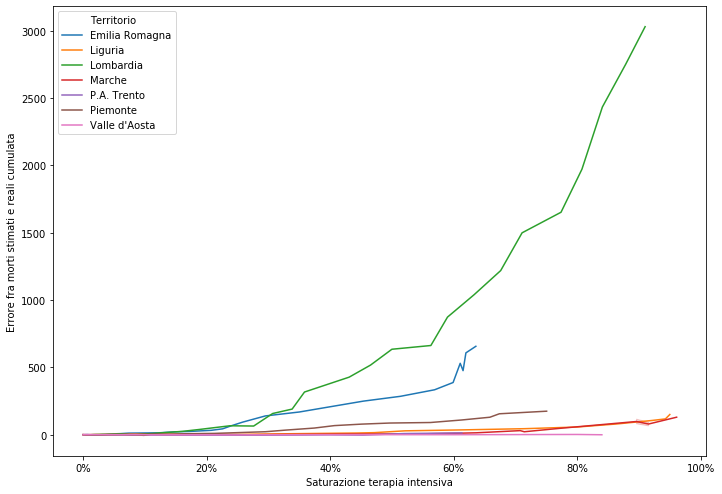

In [10]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="TI_saturazione", y="diff_morti_cumulata", hue="Territorio",data=regione_casi[regione_casi['Territorio'].isin(regione_casi[regione_casi['TI_saturazione']>=0.6]['Territorio'].unique())])
ax.set(xlabel='Saturazione terapia intensiva', ylabel='Errore fra morti stimati e reali cumulata')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

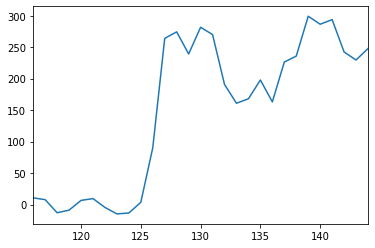

In [13]:
x = group['percentuale_positivi_per_tampone'].values
y = group['diff_morti_cumulata'].values
coefficients = np.polyfit(x, y, 5)
func = np.poly1d(coefficients)
group['percentuale_positivi_per_tampone'].apply(func).plot()

In [45]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt

def smooth_function(group):
    x = group['percentuale_positivi_per_tampone'].values
    y = group['diff_morti_cumulata'].values
    coefficients = np.polyfit(x, y, 5)
    func = np.poly1d(coefficients)
    return group['percentuale_positivi_per_tampone'].apply(func)

In [46]:
soglia = 15000
regioni_con_numero_tamponi_sopra_soglia = regione_casi.loc[regione_casi['tamponi'] > soglia,'Territorio'].unique()

In [51]:
regione_casi['diff_morti_cumulata_smoothed'] = \
    regione_casi[regione_casi['Territorio'].isin(regioni_con_numero_tamponi_sopra_soglia)]\
    .groupby('Territorio').apply(smooth_function).reset_index(drop=True)

In [56]:
regione_casi = regione_casi[~regione_casi['diff_morti_cumulata_smoothed'].isna()]

In [61]:
regione_casi[regione_casi['Territorio']=='Emilia Romagna']

,Territorio,data,stima_morti,TI_saturazione,deceduti,percentuale_positivi_per_tampone,tamponi,day,stima_morti_day,deceduti_day,diff_morti,diff_morti_cumulata,percentuale_positivi_per_tampone_smoothed,diff_morti_cumulata_smoothed


[Text(0, 0.5, 'Errore fra morti stimati e reali cumulata'),
 Text(0.5, 0, 'Percentuale di positivi per tampone')]

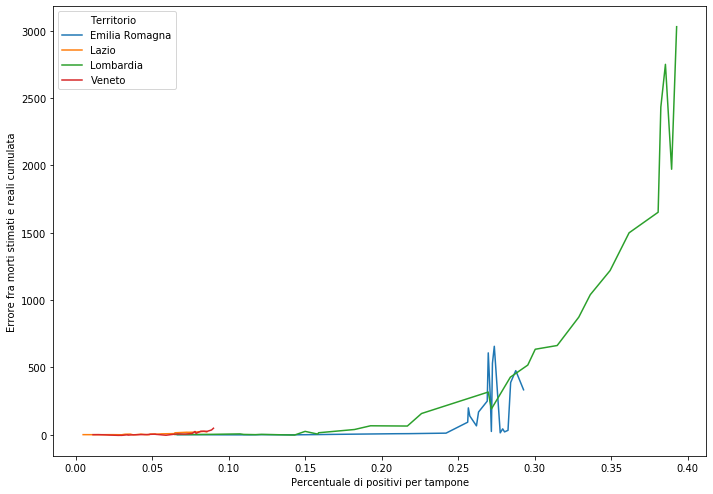

In [53]:
%matplotlib inline
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="percentuale_positivi_per_tampone", y="diff_morti_cumulata", hue="Territorio",sizes = 'percentuale_positivi_per_tampone_smoothed', data=regione_casi[regione_casi['Territorio'].isin(regioni_con_numero_tamponi_sopra_soglia)])
ax.set(ylabel='Errore fra morti stimati e reali cumulata', xlabel='Percentuale di positivi per tampone')

In [195]:
regioni['percentuale_positivi_per_tampone'] = regioni['totale_casi']/regioni['tamponi']

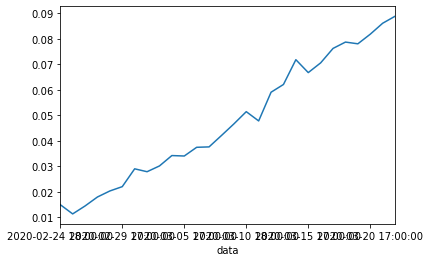

In [191]:
regioni[regioni['denominazione_regione']=='Veneto'].set_index('data')['percentuale_positivi_per_tampone'].plot()

In [177]:
regione_casi[regione_casi['Territorio'].isin(regione_casi[regione_casi['TI_saturazione']>=0.6]['Territorio'].unique())].groupby('Territorio')[['diff_morti_cumulata','TI_saturazione']].apply(estrai_correlazione)

Territorio
Emilia Romagna    0.937385
Liguria           0.892160
Lombardia         0.912923
Marche            0.757654
P.A. Trento      -0.268045
Piemonte          0.954379
Valle d'Aosta    -0.878690
dtype: float64

In [159]:
regione_casi[regione_casi['TI_saturazione']>=0.6]['Territorio'].unique()

array(['Emilia Romagna', 'Liguria', 'Lombardia', 'Marche', 'P.A. Trento',
       'Piemonte', "Valle d'Aosta"], dtype=object)

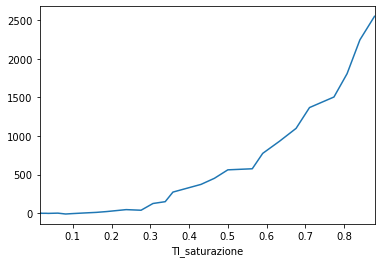

In [151]:
regione_casi[regione_casi['Territorio']=='Lombardia'].set_index('TI_saturazione')['diff_morti_cumulata'].plot()

In [ ]:
regione_casi[regione_casi['Territorio'] == 'Lombardia'][['data','nuovi_attualmente_positivi_shift','']]

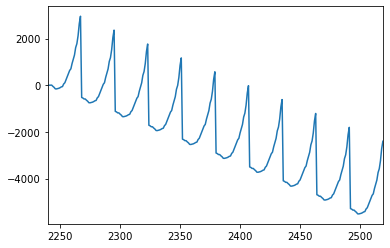

In [19]:
regione_casi[regione_casi['Territorio'] == 'Lombardia']['diff_morti_cumulata']

In [47]:
regione_casi.groupby('Territorio',as_index = False)[['diff_morti','diff_morti_perc']].mean().sort_values(by= 'diff_morti_perc', ascending = False)

,Territorio,diff_morti,diff_morti_perc
8,Lombardia,2549.876309,0.737811
4,Emilia Romagna,545.125402,0.668046
10,Molise,4.586225,0.655175
7,Liguria,100.215734,0.586057
9,Marche,94.372487,0.512894
13,Piemonte,116.819542,0.412790
0,Abruzzo,12.345773,0.374114
5,Friuli Venezia Giulia,13.512737,0.287505
14,Puglia,5.793883,0.186899
6,Lazio,8.564480,0.161594


In [45]:
andamento = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json')

In [2]:
regioni = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json',dtype = {'deceduti':float})
andamento = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json')
province = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json')

In [3]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def trova_giorno_innesco(group):
    x = list(group['day'].values)
    y = list(group['totale_casi'].values)
    kn = KneeLocator(x, y, curve='convex', direction='increasing',interp_method='polynomial')
    return kn.knee

In [4]:
FMT = '%Y-%m-%d %H:%M:%S'
date = regioni['data']
regioni['day_year'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

In [5]:
regioni = regioni[regioni['denominazione_regione']!= 'In fase di definizione/aggiornamento'].reset_index(drop=True)

In [6]:
regioni['day'] = regioni.groupby('denominazione_regione')['stato'].cumcount()+1

In [7]:
regioni['giorno_innesco'] = regioni.groupby('denominazione_regione').apply(trova_giorno_innesco).reset_index(drop=True)
regioni['giorno_innesco'] = regioni.groupby('denominazione_regione')['giorno_innesco'].transform('max')

In [8]:
regioni['innesco'] = 0
regioni.loc[regioni['day']>= regioni['giorno_innesco'],'innesco'] = 1
regioni['giorni_da_innesco'] = regioni[regioni['innesco']==1].groupby('denominazione_regione')['stato'].cumcount()+1

In [3]:
province = province[province['denominazione_provincia']!= 'In fase di definizione/aggiornamento'].reset_index(drop=True)

In [4]:
province['day'] = province.groupby('denominazione_provincia')['stato'].cumcount()+1

In [5]:
province['diff_media_mobile_3'] = province['totale_casi'].diff().rolling(5).mean()
province['innesco'] = 0
province.loc[province['diff_media_mobile_3']> 15 , 'innesco'] = 1
province['giorni_da_innesco'] = province[province['innesco']==1].groupby('denominazione_provincia')['stato'].cumcount()+1

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


In [10]:
def trova_giorno_innesco(group):
    x = list(group['day'].values)
    y = list(group['deceduti'].values)
    kn = KneeLocator(x, y, curve='convex', direction='increasing',interp_method='polynomial')
    return kn.knee

In [95]:
regioni.columns

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare',
       'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi', 'day_year',
       'day', 'giorno_innesco', 'innesco', 'giorni_da_innesco'],
      dtype='object')

In [92]:
regioni['denominazione_regione'].unique()

array(['Abruzzo', 'Basilicata', 'P.A. Bolzano', 'Calabria', 'Campania',
       'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria',
       'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna',
       'Sicilia', 'Toscana', 'P.A. Trento', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)

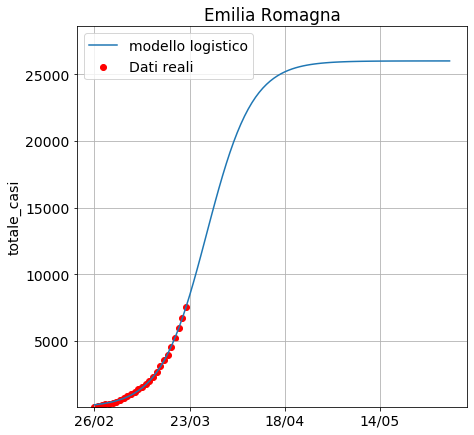

In [97]:
variabile = 'totale_casi'
#variabile = 'deceduti'
regione = 'Emilia Romagna'
x = list(regioni[(regioni['denominazione_regione']== regione)&(regioni['deceduti']>0)]['day_year'].values)
y = list(regioni[(regioni['denominazione_regione']== regione)&(regioni['deceduti']>0)][variabile].values)
z = list(regioni[(regioni['denominazione_regione']== regione)&(regioni['deceduti']>0)]['data'].values)
fit = curve_fit(logistic_model,x,y,p0=[2,100,max(y)])
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
a,b,c = fit[0]
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

i=0
posizioni = []
date= []
for day in range(min(x),sol):
    if i%round((sol-len(x))/5)==0:
        posizioni.append(day)
        data = datetime.strptime(z[0], FMT) + timedelta(days=i)
        date.append(data.strftime('%d/%m'))
    i+=1

pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Dati reali",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="modello logistico" )
plt.legend()
plt.title(regione)
plt.xticks(posizioni, date)
plt.ylabel(f"{variabile}")
plt.ylim((min(y)*0.9,c*1.1))
plt.grid()
plt.show()

In [8]:
province['giorno_innesco'] = province.groupby('denominazione_provincia').apply(trova_giorno_innesco).reset_index(drop=True)
province['giorno_innesco'] = province.groupby('denominazione_provincia')['giorno_innesco'].transform('max')

In [9]:
province['innesco'] = 0
province.loc[province['day']>= province['giorno_innesco'],'innesco'] = 1
province['giorni_da_innesco'] = province[province['innesco']==1].groupby('denominazione_provincia')['stato'].cumcount()

In [11]:
fig = px.line(province[(province['innesco']==1)&(province['denominazione_regione']== 'Calabria')], x="giorni_da_innesco", y="totale_casi", color='denominazione_provincia')
fig.show()

In [6]:
url ='https://raw.githubusercontent.com/pcm-dpc/COVID-19/blob/master/dati-regioni/dpc-covid19-ita-regioni-20200224.csv'

In [2]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [7]:
df = pd.read_csv(url,sep=',')

HTTPError: HTTP Error 404: Not Found

In [7]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )
#df['data'] = df.reset_index()['index']

In [8]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [9]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])

In [10]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [11]:
a,b,c = fit[0]

In [13]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

###### 

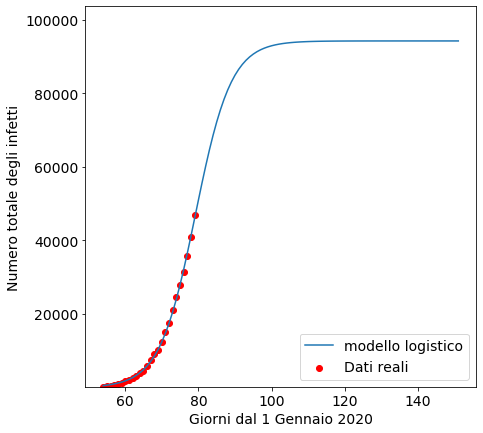

In [15]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Dati reali",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="modello logistico" )
plt.legend()
plt.xlabel("Giorni dal 1 Gennaio 2020")
plt.ylabel("Numero totale degli infetti")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

In [26]:
df = pd.read_csv(url)